In [1]:
from pathlib import Path
import csv
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

## Alpaca

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret key
alpaca_key = os.getenv('API_KEY')
alpaca_secret = os.getenv('API_SECRET_KEY')

# 
api = tradeapi.REST(alpaca_key, alpaca_secret, api_version='v2')

In [27]:
# spy = stocks -> agg = bonds
tickers = ["SPY", "AGG"]
timeframe = '1D'
end_date = pd.Timestamp('2020-12-31', tz='America/New_York').isoformat()
start_date = pd.Timestamp('2020-01-01', tz = 'America/New_York').isoformat()
df_alpaca = api.get_barset(
    tickers,
    timeframe, 
    limit=None,
    start = start_date,
    end = end_date, 
    after = None, 
    until = None, 
).df

df_alpaca.head(2)

AGG                                        SPY  \
                             open    high     low    close    volume    open   
time                                                                           
2020-08-11 00:00:00-04:00  119.11  119.21  118.84  118.985  11071582  336.85   
2020-08-12 00:00:00-04:00  118.73  118.89  118.65  118.760   9097248  335.44   

                                                                
                             high       low   close     volume  
time                                                            
2020-08-11 00:00:00-04:00  337.54  332.0100  332.82  118234337  
2020-08-12 00:00:00-04:00  338.28  332.8377  337.42   91230107

In [16]:
df_alpaca.drop(columns =['open', 'high', 'low', 'volume'], level = 1, inplace= True)
df_alpaca.head()

,AGG,SPY
,close,close
time,,
2020-08-11 00:00:00-04:00,118.985,332.82
2020-08-12 00:00:00-04:00,118.760,337.42
2020-08-13 00:00:00-04:00,118.320,336.86
2020-08-14 00:00:00-04:00,118.230,336.86
2020-08-17 00:00:00-04:00,118.330,337.88


## Monte Carlo Simulation

In [17]:
daily_returns_alpaca = df_alpaca.pct_change()
daily_returns_alpaca.head()

,AGG,SPY
,close,close
time,,
2020-08-11 00:00:00-04:00,NaN,NaN
2020-08-12 00:00:00-04:00,-0.001891,0.013821
2020-08-13 00:00:00-04:00,-0.003705,-0.001660
2020-08-14 00:00:00-04:00,-0.000761,0.000000
2020-08-17 00:00:00-04:00,0.000846,0.003028


In [19]:
# CALCULATE MEAN

spy_avg_daily_return_alpaca = daily_returns_alpaca.mean()['SPY']['close']
eth_avg_daily_return_alpaca = daily_returns_alpaca.mean()['AGG']['close']
print(f"SPY mean: {spy_avg_daily_return_alpaca}")
print(f"ETH mean: {eth_avg_daily_return_alpaca}")

SPY mean: 0.0012355537166102721
ETH mean: -6.538523090188825e-05


In [21]:
# CALCULATE VOLATILITY

spy_std_alpaca = daily_returns_alpaca.std()['SPY']['close']
eth_std_alpaca = daily_returns_alpaca.std()['AGG']['close']
print(f"SPY std: {spy_std_alpaca}")
print(f"ETH std: {eth_std_alpaca}")

SPY std: 0.011039376839430872
ETH std: 0.0017258131631013463


In [23]:
# Save last day's closing price

spy_close_alpaca = df_alpaca['SPY']['close'][-1]
eth_close_alpaca = df_alpaca['AGG']['close'][-1]
print(f"SPY close: {spy_close_alpaca}")
print(f"ETH close: {eth_close_alpaca}")

SPY close: 373.85
ETH close: 118.2


In [24]:
# parameters of monte carlo simulation
number_simulations = 500
number_records = 252*30  # 252 trading days in the year and 30 years
simulated_price_df_alpaca = pd.DataFrame()
portfolio_cumulative_returns_alpaca = pd.DataFrame()

In [25]:
# run monte carlo simulation

for n in range(number_simulations):
    spy_simulated_prices = [spy_close_alpaca]
    eth_simulated_prices = [eth_close_alpaca]
    
    for i in range(number_records):
        spy_simulated_price = spy_simulated_prices[-1] * (1+np.random.normal(spy_avg_daily_return_alpaca,spy_std_alpaca))
        eth_simulated_price = eth_simulated_prices[-1] * (1+np.random.normal(eth_avg_daily_return_alpaca,eth_std_alpaca))
        
        spy_simulated_prices.append(spy_simulated_price)
        eth_simulated_prices.append(eth_simulated_price)
        
    simulated_price_df_alpaca['SPY prices'] = pd.Series(spy_simulated_prices)
    simulated_price_df_alpaca['ETH prices'] = pd.Series(eth_simulated_prices)
    
    simulated_daily_returns = simulated_price_df_alpaca.pct_change()
    
    weights = [0.6, 0.4]
    
    porfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns_alpaca[n] = (1+porfolio_daily_returns.fillna(0)).cumprod()
    
portfolio_cumulative_returns_alpaca.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996247,0.998704,1.006678,0.996216,0.997109,1.000114,1.002681,1.005848,1.009314,0.998231,...,0.993723,0.988046,0.996894,1.001414,0.999979,1.000832,1.015495,1.007867,1.008237,1.005482
2,1.000512,0.990406,1.020840,0.989175,0.987182,0.993716,1.007104,1.005512,1.013511,0.992685,...,0.993620,0.998599,0.995055,0.999502,1.001977,1.006951,1.025276,1.015802,1.016587,1.001667
3,0.997774,0.995270,1.013746,0.988300,0.985744,0.999152,1.003217,1.009469,1.010228,1.001279,...,0.986483,1.000000,0.993907,0.989679,0.985710,1.009105,1.025040,1.018079,1.005212,1.008572
4,0.994258,0.990439,1.024661,0.989268,0.972451,0.991245,1.005428,1.009593,1.006477,0.997055,...,0.992728,1.005315,0.998080,0.983989,0.978532,1.006919,1.030605,1.009956,1.011184,1.011210


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Returns'}>

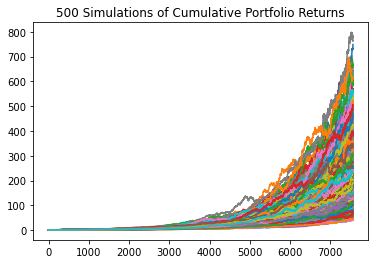

In [26]:
plot_title = f"{n+1} Simulations of Cumulative Portfolio Returns"
portfolio_cumulative_returns_alpaca.plot(legend = None, title = plot_title)